In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

2023-12-14 09:09:06.216029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 09:09:06.681240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-14 09:09:06.681273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-14 09:09:06.817974: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 09:09:08.949914: W tensorflow/stream_executor/pla

# Thank you Sandya

In [ ]:
## Loading Datasets & Preprocessing

def preprocess(df, value):
    ## only want years 2011-2012
    # except for 2016
    required_columns = ['Province'] + [str(year) for year in range(2011, 2022) if (str(year) in df.columns) and year != 2016]
    filtered_df = df[required_columns]

    ## make it 1 row = 1 province at 1 year instead of 1 province
    melted_df = pd.melt(filtered_df, id_vars='Province', var_name='Year', value_name=value)

    ## making the datatype easy to work with
    # year object to datetime
    melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

    melted_df['Year'] = melted_df['Year'].apply(lambda x: x.year)

    # some rows have - as a value which cannot be converted to float, so turn to nan first
    melted_df[value] = pd.to_numeric(melted_df[value].replace('-', pd.NA), errors='coerce')

    return melted_df

target datasets

In [ ]:
# be mindful that this dataset does not have 2016 year
energy_consumption = pd.read_csv("/work/Energy Consumption.csv")
energy_consumption = preprocess(energy_consumption, 'energy_consumption')
energy_consumption

,Province,Year,energy_consumption
0,ACEH,2011,1579.77
1,SUMATERA UTARA,2011,7194.03
2,SUMATERA BARAT,2011,2403.10
3,RIAU,2011,2361.15
4,JAMBI,2011,1054.17
...,...,...,...
345,MALUKU,2021,582.88
346,MALUKU UTARA,2021,637.04
347,PAPUA BARAT,2021,583.21
348,PAPUA,2021,1237.64


In [ ]:
energy_generation = pd.read_csv("/work/egeneration.csv")
# energy_generation = preprocess(energy_generation, 'energy_generation')
energy_generation

,Province,energy_generated,Year
0,ACEH,794.16,2011
1,SUMATERA UTARA,15342.39,2011
2,SUMATERA BARAT,287.05,2011
3,RIAU,742.90,2011
4,JAMBI,18.70,2011
...,...,...,...
345,MALUKU,969.89,2021
346,MALUKU UTARA,377.04,2021
347,PAPUA BARAT,677.34,2021
348,PAPUA,1360.61,2021


In [ ]:
energy_capacity = pd.read_csv("/work/Energy Capacity.csv")
energy_capacity = preprocess(energy_capacity, 'energy_capacity')
energy_capacity

,Province,Year,energy_capacity
0,ACEH,2011,159.26
1,SUMATERA UTARA,2011,2450.67
2,SUMATERA BARAT,2011,33.45
3,RIAU,2011,111.23
4,JAMBI,2011,12.82
...,...,...,...
345,MALUKU,2021,390.74
346,MALUKU UTARA,2021,157.88
347,PAPUA BARAT,2021,267.51
348,PAPUA,2021,525.64


features

socioeconomic

In [ ]:
homeowners = pd.read_csv("/work/Homeowners.csv")
homeowners.drop([35,36,37,38], inplace=True) # delete subtext
homeowners = preprocess(homeowners, 'prop_homeowners')
homeowners

,Province,Year,prop_homeowners
0,ACEH,2011,79.02
1,SUMATERA UTARA,2011,66.07
2,SUMATERA BARAT,2011,69.51
3,RIAU,2011,68.42
4,JAMBI,2011,78.02
...,...,...,...
345,MALUKU,2021,75.13
346,MALUKU UTARA,2021,83.40
347,PAPUA BARAT,2021,76.03
348,PAPUA,2021,83.20


In [ ]:
household_work = pd.read_csv("/work/Household working.csv")
household_work = household_work.rename(columns={'Unnamed: 0': 'Province'})
household_work = preprocess(household_work, 'prop_working')
household_work

,Province,Year,prop_working
0,Aceh,2011,87.13
1,Sumatera Utara,2011,90.28
2,Sumatera Barat,2011,86.66
3,R i a u,2011,91.90
4,J a m b i,2011,90.87
...,...,...,...
345,Maluku,2021,86.18
346,Maluku Utara,2021,89.85
347,Papua Barat,2021,91.64
348,P a p u a,2021,94.32


In [ ]:
school_inattend = pd.read_csv("/work/School Inattendance.csv")
school_inattend = preprocess(school_inattend, 'prop_school_absentees')
school_inattend

,Province,Year,prop_school_absentees
0,Aceh,2011,3.17
1,Sumatera Utara,2011,2.34
2,Sumatera Barat,2011,2.02
3,Riau,2011,2.39
4,Jambi,2011,3.56
...,...,...,...
345,Maluku,2021,2.27
346,Maluku Utara,2021,1.08
347,Papua Barat,2021,3.55
348,Papua,2021,25.55


In [ ]:
toilet_access = pd.read_csv("/work/Toilet Facility Access.csv")
toilet_access.drop([35,36,37,38,39], inplace=True) # delete subtext
toilet_access = preprocess(toilet_access, 'prop_toilet_access')
toilet_access

,Province,Year,prop_toilet_access
0,Aceh,2011,60.34
1,Sumatera Utara,2011,74.88
2,Sumatera Barat,2011,54.65
3,Riau,2011,83.81
4,Jambi,2011,68.12
...,...,...,...
345,Maluku,2021,72.87
346,Maluku Utara,2021,69.73
347,Papua Barat,2021,75.48
348,Papua,2021,63.34


economic

In [ ]:
gdp = pd.read_csv("/work/GDP.csv")
# gdp represented with columns
gdp = gdp.replace(',', '', regex=True)
# then preprocess
gdp = preprocess(gdp, 'gdp')
gdp

,Province,Year,gdp
0,Aceh,2011,108217.63
1,North Sumatra,2011,377037.10
2,West Sumatra,2011,118674.29
3,Riau,2011,485649.34
4,Jambi,2011,103522.91
...,...,...,...
345,Maluku,2021,48564.22
346,North Maluku,2021,52359.85
347,West Papua,2021,85072.86
348,Papua,2021,235343.25


In [ ]:
population = pd.read_csv("/work/Population.csv")
# population.drop([35,36,37,38], inplace=True) # delete subtext
population = preprocess(population, 'population')
population

,Province,Year,population
0,Aceh,2011,4619.0
1,Sumatera Utara,2011,13220.0
2,Sumatera Barat,2011,4933.0
3,Riau,2011,5726.0
4,Kep. Riau,2011,3168.0
...,...,...,...
345,Maluku,2021,1862.6
346,Maluku Utara,2021,1299.2
347,Papua Barat,2021,1156.8
348,Papua,2021,4355.5


physical / climate

In [ ]:
# note! missing 2011
land_area = pd.read_csv("/work/Land Area.csv")
# Loop through specified columns, remove spaces
columns_to_convert = [str(year) for year in range(2012, 2022)]
for column_name in columns_to_convert:
    land_area[column_name] = land_area[column_name].str.replace(' ', '')

land_area = preprocess(land_area, 'land_area')
land_area

,Province,Year,land_area
0,Aceh,2011,NaN
1,Sumatera Utara,2011,NaN
2,Sumatera Barat,2011,NaN
3,Riau,2011,NaN
4,Kepulauan Riau,2011,NaN
...,...,...,...
345,Maluku,2021,46914.03
346,Maluku Utara,2021,31982.50
347,Papua,2021,319036.05
348,Papua Barat,2021,99671.63


In [ ]:
# note! missing 2016, 2017, 2018, 2019, 2020, 2021
rainy_days = pd.read_csv("/work/Rainy Days.csv")
rainy_days = preprocess(rainy_days, 'num_rainy_days')
rainy_days

,Province,Year,num_rainy_days
0,Aceh,2011,150.0
1,Sumatera Utara,2011,225.0
2,Sumatera Barat,2011,NaN
3,Riau,2011,211.0
4,Jambi,2011,209.0
...,...,...,...
165,Sulawesi Barat,2015,93.0
166,Maluku,2015,167.0
167,Maluku Utara,2015,127.0
168,Papua Barat,2015,218.0


Combine to create final dataframe

In [ ]:
dfs_list = [energy_consumption, energy_generation, energy_capacity, homeowners, household_work, school_inattend, toilet_access,gdp, population, land_area]  # Add all your datasets here
combined_df = pd.concat(dfs_list, axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df

,Province,Year,energy_consumption,energy_generated,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,1579.77,794.16,159.26,79.02,87.13,3.17,60.34,108217.63,4619.0,NaN
1,SUMATERA UTARA,2011,7194.03,15342.39,2450.67,66.07,90.28,2.34,74.88,377037.10,13220.0,NaN
2,SUMATERA BARAT,2011,2403.10,287.05,33.45,69.51,86.66,2.02,54.65,118674.29,4933.0,NaN
3,RIAU,2011,2361.15,742.90,111.23,68.42,91.90,2.39,83.81,485649.34,5726.0,NaN
4,JAMBI,2011,1054.17,18.70,12.82,78.02,90.87,3.56,68.12,103522.91,3168.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
345,MALUKU,2021,582.88,969.89,390.74,75.13,86.18,2.27,72.87,48564.22,1862.6,46914.03
346,MALUKU UTARA,2021,637.04,377.04,157.88,83.40,89.85,1.08,69.73,52359.85,1299.2,31982.50
347,PAPUA BARAT,2021,583.21,677.34,267.51,76.03,91.64,3.55,75.48,85072.86,1156.8,319036.05
348,PAPUA,2021,1237.64,1360.61,525.64,83.20,94.32,25.55,63.34,235343.25,4355.5,99671.63


# Ethan Edits

## Notes

Edits: 
- made year just the year rather than like a timestamp
- got rid of all rows with year of 2016

Need to change it to look like the example df; 
2011 features with 2014 target variable 
-->
2018 features with 2021 target variable 

therefore, we don't need any data after 2018

## Feature_df: Generation and Description

In [ ]:
drop_post_2019 = combined_df[combined_df['Year'] < 2019]
feature_df = drop_post_2019.drop(['energy_consumption', 'energy_generated', 'energy_capacity'], axis=1)
feature_df

,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,NaN
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,NaN
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,NaN
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,NaN
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,NaN
...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63


In [ ]:
count = 0
for col in feature_df.columns:
    num_nans = feature_df[col].isna().sum()
    count += num_nans
    print(col + ': ' + str(num_nans))
print(count)

Province: 0
Year: 0
prop_homeowners: 4
prop_working: 4
prop_school_absentees: 4
prop_toilet_access: 4
gdp: 2
population: 6
land_area: 34
58


## Add Target(s) to feature_df

In [ ]:
def add_target_to_feature_df(feature_df, target_df, target_name):
    full_df = feature_df.copy()
    clean_target = target_df[target_df['Year'] >= 2014].reset_index()
    full_df['target: ' + target_name] = clean_target[target_name]

    print('num nans in target col: ' + str(clean_target[target_name].isna().sum()))

    return full_df
    
def MAPE(y_pred, y_true):
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
    return mape

In [ ]:
egen_df = add_target_to_feature_df(feature_df, energy_generation, 'energy_generated')
egen_df

num nans in target col: 7


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,target: energy_generated
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4619.0,NaN,582.06
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13220.0,NaN,18028.30
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,4933.0,NaN,179.47
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5726.0,NaN,892.63
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3168.0,NaN,127.89
...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1749.5,46914.03,969.89
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1218.8,31982.50,377.04
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,941.4,319036.05,677.34
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3300.2,99671.63,1360.61


# Modeling

## Sklearn Linear Regression

Before starting linear regresson, we dropped the rows with NaN values of columns that had them. We split up the data into a features dataframe (X) and a target variable for energy generation (y). We decided on a test size of 0.25 because a 75-25 training/testing split is a common ration for providing enough data to train the model, and test on a reasonable subset after. 

In [ ]:
# egen_df
pq1_df = egen_df.copy().drop(['Province', 'Year'], axis=1).dropna()
X = pq1_df.drop('target: energy_generated', axis=1)
y = pq1_df['target: energy_generated']

egen_X_train, egen_X_test, egen_y_train, egen_y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [ ]:
lr = LinearRegression()
lr.fit(egen_X_train, egen_y_train)
egen_y_pred = lr.predict(egen_X_test)

mean_squared_error(egen_y_test, egen_y_pred, squared = False)

#sns.scatterplot(x = egen_y_test, y = egen_y_pred)

10164.425673613696

In [ ]:
# MAPE value
print(MAPE(egen_y_pred,egen_y_test))

8.478420456336801


In [ ]:
find_2024 = combined_df[combined_df['Year'] ==2021].reset_index().drop(['index', 'Year','energy_consumption','energy_capacity'], axis=1)
predicted_2024_ecap = lr.predict(find_2024.drop(['Province', 'energy_generated'],axis=1))
find_2024['2024 Predicted Energy Generation (GWh)'] = predicted_2024_ecap
lr_predicted = find_2024[['Province', '2024 Predicted Energy Generation (GWh)']]

lr_predicted

,Province,2024 Predicted Energy Generation (GWh)
0,ACEH,5418.384978
1,SUMATERA UTARA,15442.592371
2,SUMATERA BARAT,3716.035732
3,RIAU,9846.546393
4,JAMBI,4652.893860
5,SUMATERA SELATAN,6882.743852
6,BENGKULU,7468.304629
7,LAMPUNG,6377.108290
8,KEP. BANGKA BELITUNG,3067.253042
9,KEP. RIAU,6428.406475


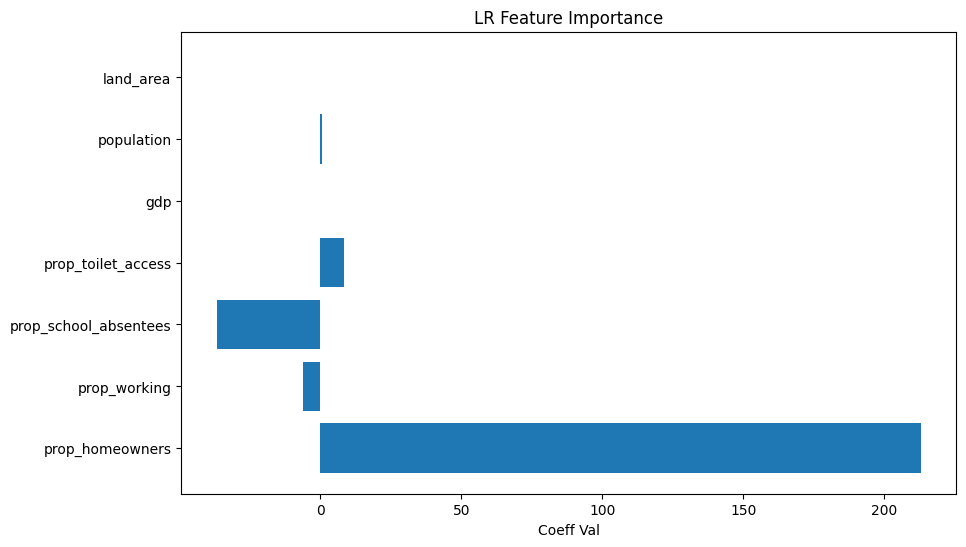

In [ ]:
feature_names = X.columns
coefficients = lr.coef_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coeff Val')
plt.title('LR Feature Importance')
plt.show()

## Sklearn Ridge Regression

We opted for Ridge over Lasso regression because Ridge regression can handle correlated features and Lasso cannot; our data currently (as of 12/8) has correlated features such as , but this can change so maybe will switch to Lasso in the future

In [ ]:
from sklearn.linear_model import Ridge

# egen_df
pq1_df = egen_df.copy().drop(['Province', 'Year'], axis=1).dropna()
X = pq1_df.drop('target: energy_generated', axis=1)
y = pq1_df['target: energy_generated']

egen_X_train, egen_X_test, egen_y_train, egen_y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

rdge = Ridge(alpha=1.0)
rdge.fit(egen_X_train, egen_y_train)

egen_y_pred = rdge.predict(egen_X_test)

mean_squared_error(egen_y_test, egen_y_pred, squared = False)



10164.417410752887

In [ ]:
# MAPE value
print(MAPE(egen_y_test,egen_y_pred))

0.8605270974164252


### 2024 Ridge Regression Prediction

In [ ]:
df_2021 = combined_df[combined_df['Year'] == 2021]
#df_2021 = 



#x_2021 = df_2021.drop('energy_generated', axis=1)
#y_2021 = df_2021['energy_generated']
#y_pred_2024 = rdge.predict(x_2021)
df_2021

,Province,Year,energy_consumption,energy_generated,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
315,ACEH,2021,3074.47,3001.78,904.88,80.51,86.55,1.03,80.38,184976.30,5333.7,57956.00
316,SUMATERA UTARA,2021,11748.40,12985.88,4603.58,67.57,88.61,1.44,88.91,859870.95,14936.2,72981.23
317,SUMATERA BARAT,2021,3646.20,4396.18,1031.49,68.34,87.96,0.90,79.04,252749.65,5580.2,42012.89
318,RIAU,2021,6108.32,5389.06,1429.86,72.52,91.23,0.71,92.30,843211.15,6493.6,87023.66
319,JAMBI,2021,2111.92,730.00,369.81,84.21,90.50,2.17,87.90,233725.46,2118.2,8201.72
320,SUMATERA SELATAN,2021,5593.93,11019.15,2286.43,81.32,90.56,0.81,82.81,491566.45,3585.1,50058.16
321,BENGKULU,2021,1058.61,2689.06,529.89,84.32,92.19,2.07,88.62,79576.33,8550.9,91592.43
322,LAMPUNG,2021,5176.94,5436.19,1087.92,89.40,91.69,1.66,91.92,371903.17,1473.2,16424.06
323,KEP. BANGKA BELITUNG,2021,1369.20,1498.09,354.93,83.14,88.33,2.33,92.46,85942.70,2032.9,19919.33
324,KEP. RIAU,2021,3478.63,3380.70,757.43,66.83,88.71,1.29,94.55,275636.33,9081.8,34623.80


In [ ]:
find_2024 = combined_df[combined_df['Year'] ==2021].reset_index().drop(['index', 'Year','energy_consumption','energy_capacity'], axis=1)
predicted_2024_ecap = rdge.predict(find_2024.drop(['Province', 'energy_generated'],axis=1))
find_2024['2024 Predicted Energy Generation (GWh)'] = predicted_2024_ecap
rdge_predicted = find_2024[['Province', '2024 Predicted Energy Generation (GWh)']]

rdge_predicted

,Province,2024 Predicted Energy Generation (GWh)
0,ACEH,5418.184195
1,SUMATERA UTARA,15442.784832
2,SUMATERA BARAT,3716.216443
3,RIAU,9846.534150
4,JAMBI,4652.658456
5,SUMATERA SELATAN,6882.536526
6,BENGKULU,7468.150508
7,LAMPUNG,6376.697912
8,KEP. BANGKA BELITUNG,3067.004610
9,KEP. RIAU,6428.649232


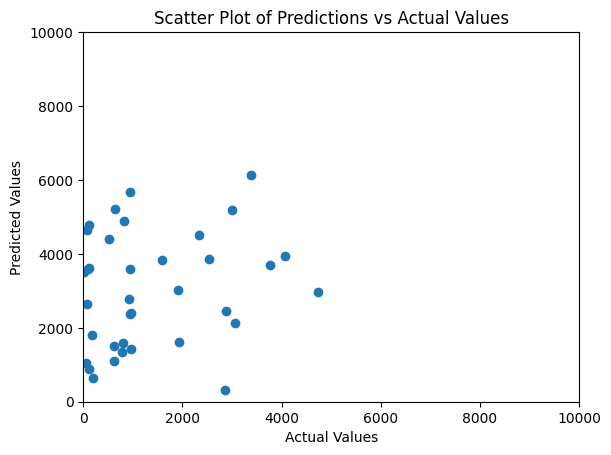

In [ ]:
plt.scatter(egen_y_test, egen_y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Predictions vs Actual Values")
plt.xlim(0, 10000)  
plt.ylim(0, 10000)
plt.show()

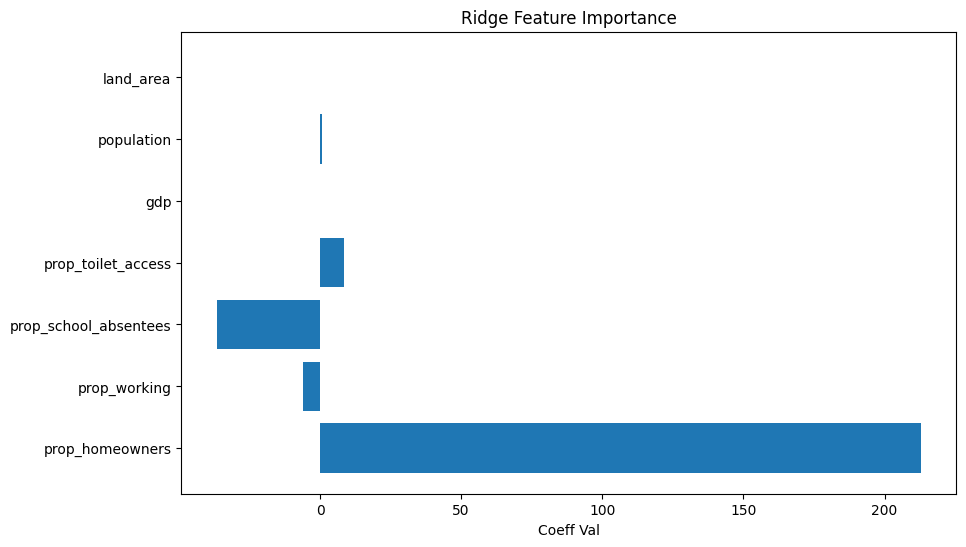

In [ ]:
feature_names = X.columns
coefficients = rdge.coef_

# feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coeff Val')
plt.title('Ridge Feature Importance')
plt.show()

## Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

# egen_df
pq1_df = egen_df.copy().drop(['Province', 'Year'], axis=1).dropna()
X = pq1_df.drop('target: energy_generated', axis=1)
y = pq1_df['target: energy_generated']

egen_X_train, egen_X_test, egen_y_train, egen_y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

las = Lasso(alpha=1.0)
las.fit(egen_X_train, egen_y_train)

egen_y_pred = las.predict(egen_X_test)
mean_squared_error(egen_y_test, egen_y_pred, squared = False)


10164.447688955584

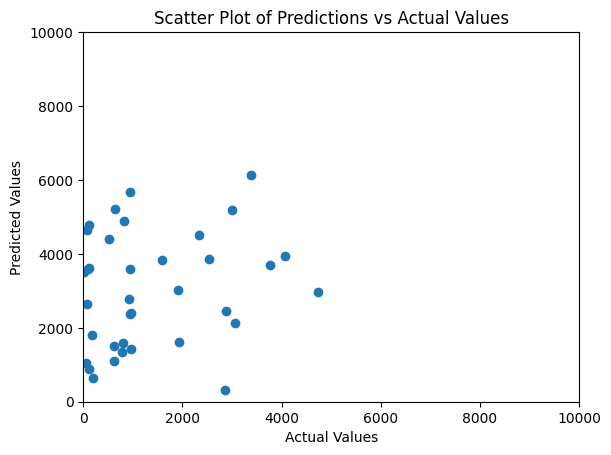

In [ ]:
plt.scatter(egen_y_test, egen_y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Predictions vs Actual Values")
plt.xlim(0, 10000)  # Adjust these limits based on your data
plt.ylim(0, 10000)  # Adjust these limits based on your data
plt.show()

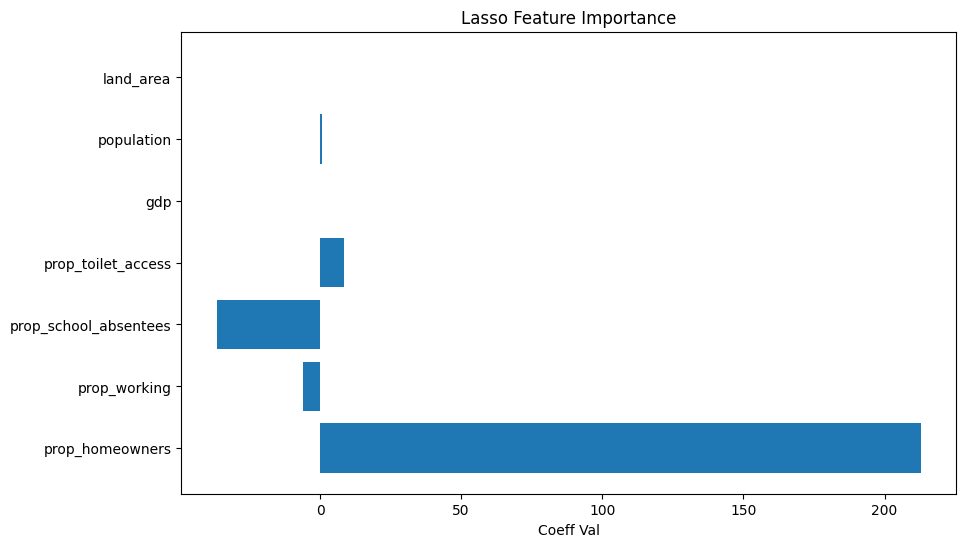

In [ ]:
feature_names = X.columns
coefficients = las.coef_

# feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coeff Val')
plt.title('Lasso Feature Importance')
plt.show()

## LSTM (Neural Network)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# egen_df
pq2_df = egen_df.copy().drop(['Province'], axis=1).dropna()


# Split the data into training (2011-2017) and testing (2018-2021)
train_data = pq2_df[pq2_df['Year'].between(2011, 2017)]
test_data = pq2_df[pq2_df['Year'].between(2018, 2021)]

y_train = train_data['target: energy_generated']
X_train = train_data.drop(['Year', 'target: energy_generated'], axis=1)

y_test = test_data['target: energy_generated']
X_test = test_data.drop(['Year', 'target: energy_generated'], axis=1)


# Reshape the input data 
steps = 3
features = X_train.shape[1]
X_train_lstm, y_train_lstm = [], []

for i in range(len(X_train) - steps):
    X_train_lstm.append(X_train.iloc[i:(i + steps)].values)
    y_train_lstm.append(y_train.iloc[i + steps])

X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)


X_test_lstm, y_test_lstm = [], []

for i in range(len(X_test) - steps):
    X_test_lstm.append(X_test.iloc[i:(i + steps)].values)
    y_test_lstm.append(y_test.iloc[i + steps])

X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)

# Build model
model = Sequential()
model.add(LSTM(units=50, activation='linear', input_shape=(steps, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')  # mean squared error

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=50)

# Evaluate model on test set
lstm_y_pred = model.predict(X_test_lstm)
rmse = mean_squared_error(y_test_lstm, lstm_y_pred, squared=False)

print(rmse)

2023-12-14 09:09:15.887456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-14 09:09:15.887512: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-14 09:09:15.887538: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-9a2d3571-826e-4759-814d-0768207fd99f): /proc/driver/nvidia/version does not exist
2023-12-14 09:09:15.887828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 152151

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a2d3571-826e-4759-814d-0768207fd99f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>